# Final Project 
# Taylor Rohrich (trr2as) Michael Pajewski (mtp9k) Yusheng Jiang (yj3tp)

### The get repo can be found here: https://github.com/mtp9k/Identifying-Clickbait-SYS-60616-

In [ ]:
import sklearn
assert sklearn.__version__ >= "0.20"
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import feature_column
from tensorflow.keras.layers import Embedding, LSTM
from tensorflow.keras import layers
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import losses
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
seed = 49

### Generating Text Files

In [ ]:
!rm -r text

rm: cannot remove 'text': No such file or directory


In [ ]:
!mkdir text
!mkdir text/clickbait
!mkdir text/normal

In [ ]:
githubUrl= 'https://raw.githubusercontent.com/mtp9k/Identifying-Clickbait-SYS-60616-/main/'

In [ ]:
df = pd.read_csv(f'{githubUrl}clickbait_data.csv')

In [ ]:
from sklearn.model_selection import train_test_split
# Create split
train, test = train_test_split(df, test_size=0.1,random_state=seed)

In [ ]:
# Write to csv
train.to_csv('clickbait_train.csv',index=False)
test.to_csv('clickbait_test.csv',index=False)

In [ ]:
df = pd.read_csv('clickbait_train.csv')

In [ ]:
# get normal, clickbait
normal = df.loc[df['clickbait']==0]['headline'].values
clickbait = df.loc[df['clickbait']==1]['headline'].values

In [ ]:
# Helper function to generate examples into directory structure
def generateTensorflowTextDir(data,folderName):
    for i,line in enumerate(data):
        filename = f'{i}_{folderName}'
        with open(f"text/{folderName}/{filename}.txt", "w") as outfile:
            outfile.write(line)

In [ ]:
# Generate normal directory
generateTensorflowTextDir(normal,'normal')

In [ ]:
# Generate clickbait directory
generateTensorflowTextDir(clickbait,'clickbait')

### Generating Test Data

In [ ]:
# Get test data
testData = pd.read_csv(f'{githubUrl}clickbait_test.csv')
testText = testData['headline'].values
testLabels = testData['clickbait'].values

In [ ]:
# Get Twitter data
tweetTestData = pd.read_csv(f'{githubUrl}tweets.csv')
tweetTestText = [' '.join(map(lambda x: x.strip("\n;[]\\"), l.split(' '))) for l in tweetTestData.postText]

tweetTestLabels = np.round(tweetTestData['isClickbait'].values)

### Evaluation Helper functions

In [ ]:
from sklearn.metrics import accuracy_score
# Helper function to calculate accuracy
def getAccuracy(labels,predictions):
    return accuracy_score(labels,np.round(predictions))

In [ ]:
# Helper function to wrap model for export
def export_model(model):
    ouput = tf.keras.Sequential([
      vectorize_layer,
      model,
    ])
    return ouput

In [ ]:
# Helper function to get accuracy for the test set and twitter test set
def runEvaluation(model,returnPredictions=False):
    model_predictions= model.predict(testText)
    model_accuracy = getAccuracy(testLabels,model_predictions)
    model_tweet_predictions = model.predict(tweetTestText)
    model_tweet_accuracy = getAccuracy(tweetTestLabels,model_tweet_predictions)
    if returnPredictions:
      return model_predictions,model_tweet_predictions
    return model_accuracy,model_tweet_accuracy
    

### Parsing Text Files

In [ ]:
# Batch Size -- we set to 1 to just read it in
BATCH_SIZE = 64
DATASET_SIZE = 32000
train_size = 32000 - 6400
test_size =6400
seed = 49

In [ ]:
# Generate train data
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'text',
    batch_size=BATCH_SIZE,
    class_names=['normal','clickbait'],
    subset='training',
    validation_split=0.2, 
    seed=seed
)

Found 28800 files belonging to 2 classes.
Using 23040 files for training.


In [ ]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to normal
Label 1 corresponds to clickbait


In [ ]:
# Generate validation data
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
   'text/',
    batch_size=BATCH_SIZE,
    class_names=['normal','clickbait'],
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 28800 files belonging to 2 classes.
Using 5760 files for validation.


In [ ]:
# Example output
for x,y in raw_train_ds.take(1):
    print(x[0:10],y[0:10])

tf.Tensor(
[b'Gilchrist scores second fastest Test century'
 b'21 Sad Ass Mets Fan Tweets' b'Tankers taken by pirates in Indian Ocean'
 b'When Do Women Decide To Have Sex'
 b'German supermarket chain uses fingerprint ID for payment'
 b'Jayant "Dr Death" Patel arrested in Oregon, US'
 b"Quebec's Liberal premier Jean Charest wins third term"
 b'Debt Settlers Offer Promises but Little Help'
 b'Zimbabwe bans crop growing in urban areas'
 b'Wikinews interviews a Restore the Fourth organizer'], shape=(10,), dtype=string) tf.Tensor([0 1 0 1 0 0 0 0 0 0], shape=(10,), dtype=int32)


In [ ]:
# Cutom standardization code
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    return input_data
    return lowercase

In [ ]:
max_features = 5000
sequence_length = 500
# Vectorize the words in the training set
vectorize_layer = TextVectorization(
#     standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [ ]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [ ]:
# Helper function to vectorize text
def vectorize_text(text, label):
    #text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [ ]:
# Vectorize the train and validation set
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)

In [ ]:
# Cache and prefetch
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Number of embedding dimensions
embedding_dim = 40

## Experiment 1: Simple NN Performance vs Traditional ML

### Base ML Models

In [ ]:
# Helper function to convert tensorflow dataset to numpy array
def dsToNumpy(ds):
    xList=[]
    yList=[]
    for x,y in ds.unbatch():
        xList.append(x.numpy())
        yList.append(y.numpy())
    xList=np.array(xList)
    yList=np.array(yList)
    return xList,yList
# Convert ds to numpy array
x_train,y_train = dsToNumpy(train_ds)
x_val,y_val = dsToNumpy(val_ds)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Train a random forest classifier
rf = RandomForestClassifier(max_depth=10, random_state=seed).fit(x_train, y_train)
# Get predictions
predictions=rf.predict(x_val)
predictions

array([1, 1, 1, ..., 0, 0, 0], dtype=int32)

In [ ]:
# Get accuracy
getAccuracy(y_val,predictions)

0.8321180555555555

In [ ]:
from xgboost import XGBClassifier
# Train XGBoost classifier
model = XGBClassifier()
model.fit(x_train, y_train)

# make predictions for test data

y_pred = model.predict(x_val)
predictions = [round(value) for value in y_pred]

# evaluate predictions

accuracy = accuracy_score(y_val, predictions)
accuracy


0.878125

### Simple LSTM Model

In [ ]:
# Helper function to generate an LSTM model
def LSTM_nn():
  # Simple with just 32 neurons in the lSTM label
    model = tf.keras.Sequential([
      layers.Embedding(max_features, embedding_dim,input_length=sequence_length),
      LSTM(32, return_sequences=True),
      layers.GlobalAveragePooling1D(),
      layers.Dropout(0.3),
      layers.Dense(1,activation='sigmoid')])
    return model

In [ ]:
lstm_model = LSTM_nn()
# Utilize ADAM optimizer
optimizer = keras.optimizers.Adam(lr=0.0001)
# Compile
lstm_model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])
epochs = 5
# Train
history = lstm_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/5
360/360 [==============================] - 26s 26ms/step - loss: 0.5953 - accuracy: 0.6004 - val_loss: 0.1661 - val_accuracy: 0.9602
Epoch 2/5
360/360 [==============================] - 9s 25ms/step - loss: 0.1562 - accuracy: 0.9647 - val_loss: 0.1518 - val_accuracy: 0.9655
Epoch 3/5
360/360 [==============================] - 9s 25ms/step - loss: 0.1173 - accuracy: 0.9747 - val_loss: 0.1420 - val_accuracy: 0.9679
Epoch 4/5
360/360 [==============================] - 9s 25ms/step - loss: 0.0775 - accuracy: 0.9853 - val_loss: 0.1441 - val_accuracy: 0.9694
Epoch 5/5
360/360 [==============================] - 9s 25ms/step - loss: 0.0998 - accuracy: 0.9788 - val_loss: 0.1399 - val_accuracy: 0.9701


In [ ]:
# Generate predictions
export_lstm_model = export_model(lstm_model)
lstm_accuracy,lstm_tweet_accuracy = runEvaluation(export_lstm_model)

In [ ]:
print('same dataset evaluation accuracy:')
print(lstm_accuracy)
print('twitter dataset evaluation accuracy:')
print(lstm_tweet_accuracy)

same dataset evaluation accuracy:
0.971875
twitter dataset evaluation accuracy:
0.5082


## Experiment 2: NN Architecture Comparisons + Ensemble

### Simple GRU Model

In [ ]:
# Helper function to generate GRU model
def GRU_nn():
  # Simple GRU with only several layers
    model = tf.keras.Sequential([
      layers.Embedding(max_features, embedding_dim,input_length=sequence_length),
      layers.GRU(embedding_dim, return_sequences=True),
      layers.GlobalAveragePooling1D(),
      layers.Dropout(0.3),
      layers.Dense(1,activation='sigmoid')])
    return model

In [ ]:
gru_model = GRU_nn()
# Adam optimizer
optimizer = keras.optimizers.Adam(lr=0.0001)
gru_model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])
epochs = 5
# train
history = gru_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/5
360/360 [==============================] - 11s 26ms/step - loss: 0.6329 - accuracy: 0.5675 - val_loss: 0.1641 - val_accuracy: 0.9543
Epoch 2/5
360/360 [==============================] - 9s 25ms/step - loss: 0.1499 - accuracy: 0.9584 - val_loss: 0.1093 - val_accuracy: 0.9698
Epoch 3/5
360/360 [==============================] - 9s 25ms/step - loss: 0.0857 - accuracy: 0.9755 - val_loss: 0.0921 - val_accuracy: 0.9712
Epoch 4/5
360/360 [==============================] - 9s 25ms/step - loss: 0.0545 - accuracy: 0.9844 - val_loss: 0.0914 - val_accuracy: 0.9722
Epoch 5/5
360/360 [==============================] - 9s 25ms/step - loss: 0.0363 - accuracy: 0.9900 - val_loss: 0.1000 - val_accuracy: 0.9724


In [ ]:
# Make predictions
export_gru_model = export_model(gru_model)
gru_accuracy,gru_tweet_accuracy = runEvaluation(export_gru_model)

In [ ]:
print('same dataset evaluation accuracy:')
print(gru_accuracy)
print('twitter dataset evaluation accuracy:')
print(gru_tweet_accuracy)

same dataset evaluation accuracy:
0.97625
twitter dataset evaluation accuracy:
0.5209


### BERT Model

In [ ]:
!pip install -q tensorflow-text
!pip install -q tf-models-official

     |████████████████████████████████| 1.1MB 8.0MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 
     |████████████████████████████████| 37.6MB 137kB/s 
     |████████████████████████████████| 358kB 55.5MB/s 
     |████████████████████████████████| 1.2MB 49.6MB/s 
     |████████████████████████████████| 706kB 65.5MB/s 
     |████████████████████████████████| 645kB 52.4MB/s 
     |████████████████████████████████| 102kB 13.9MB/s 
     |████████████████████████████████| 174kB 67.0MB/s 


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optmizer

In [ ]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 
# Find the right bert model to get
map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}
# Get BERT and corresponding preprocess model
tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [ ]:
# Sample of how BERT preprocesses text
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

In [ ]:
# Helper function to generate a BERT neural network
def BERT_nn():
    # text input
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    # preprocess
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    # preprocess
    encoder_inputs = preprocessing_layer(text_input)
    # Have trainable layer
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    # Get output
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    # Dropout
    net = tf.keras.layers.Dropout(0.1)(net)
    # sigmoid activation function
    net = tf.keras.layers.Dense(1,activation='sigmoid')(net)
    return tf.keras.Model(text_input, net)

In [ ]:
bert_model = BERT_nn()
# Generate loss, metrics, epcohs
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()
epochs = 2
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)
# Create AdamW optimizer w/ initial learning rate
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
# Compile
bert_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)
# Fit
history = bert_model.fit(
    raw_train_ds,
    validation_data=raw_val_ds,
    epochs=epochs)

Epoch 1/2
360/360 [==============================] - 145s 388ms/step - loss: 0.2633 - binary_accuracy: 0.8723 - val_loss: 0.0531 - val_binary_accuracy: 0.9826
Epoch 2/2
360/360 [==============================] - 139s 387ms/step - loss: 0.0385 - binary_accuracy: 0.9865 - val_loss: 0.0511 - val_binary_accuracy: 0.9837


In [ ]:
# Get accuracy
bert_accuracy,bert_tweet_accuracy = runEvaluation(bert_model)

In [ ]:
print('same dataset evaluation accuracy:')
print(bert_accuracy)
print('twitter dataset evaluation accuracy:')
print(bert_tweet_accuracy)

same dataset evaluation accuracy:
0.9865625
twitter dataset evaluation accuracy:
0.6015


### Results

In [ ]:
# Compare results of these 3 models
results = pd.DataFrame({'Model':['LSTM','GRU','BERT'],'Test Set Accuracy':[lstm_accuracy,gru_accuracy,bert_accuracy],'Twitter Set Accuracy':[lstm_tweet_accuracy,gru_tweet_accuracy,bert_tweet_accuracy]})
results

,Model,Test Set Accuracy,Twitter Set Accuracy
0,LSTM,0.971875,0.5082
1,GRU,0.976250,0.5209
2,BERT,0.986563,0.6015


### Naieve Ensemble

In [ ]:
# Get predictions
lstm_pred,lstm_tweet_pred = runEvaluation(export_lstm_model,True)
gru_pred,gru_tweet_pred = runEvaluation(export_gru_model,True)
bert_pred,bert_tweet_pred = runEvaluation(bert_model,True)

In [ ]:
# Simplay average predictions
ensemble_predictions = (lstm_pred + gru_pred + bert_pred) / 3
ensemble_tweet_predictions = (lstm_tweet_pred + gru_tweet_pred + bert_tweet_pred) / 3
ensemble_acc = getAccuracy(testLabels,ensemble_predictions)
ensemble_tweet_acc = getAccuracy(tweetTestLabels,ensemble_tweet_predictions)
print('Ensemble Test Set Accuracy:')
print(ensemble_acc)
print('Ensemble Tweet Set Accuracy:')
print(ensemble_tweet_acc)

Ensemble Test Set Accuracy:
0.980625
Ensemble Tweet Set Accuracy:
0.5278


## Experiment 3: Performance of Label Smoothing

In [ ]:
# train LSTM with label smoothing
keras.backend.clear_session()
smooth_model = LSTM_nn()
label_smoothing =  0.1
optimizer = keras.optimizers.Adam(lr=0.0001)
smooth_model.compile(loss=losses.BinaryCrossentropy(from_logits=True,label_smoothing=label_smoothing),
              optimizer='adam',
              metrics=['accuracy'])
epochs = 5
# Fit
history = smooth_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/5
360/360 [==============================] - 11s 26ms/step - loss: 0.6390 - accuracy: 0.5795 - val_loss: 0.2956 - val_accuracy: 0.9582
Epoch 2/5
360/360 [==============================] - 9s 25ms/step - loss: 0.3051 - accuracy: 0.9548 - val_loss: 0.2796 - val_accuracy: 0.9656
Epoch 3/5
360/360 [==============================] - 9s 25ms/step - loss: 0.2709 - accuracy: 0.9709 - val_loss: 0.2980 - val_accuracy: 0.9563
Epoch 4/5
360/360 [==============================] - 9s 25ms/step - loss: 0.2711 - accuracy: 0.9708 - val_loss: 0.2825 - val_accuracy: 0.9656
Epoch 5/5
360/360 [==============================] - 9s 25ms/step - loss: 0.2511 - accuracy: 0.9804 - val_loss: 0.2768 - val_accuracy: 0.9677


In [ ]:
# Get test set accuracy
export_smooth_model = export_model(smooth_model)
smooth_accuracy,smooth_tweet_accuracy = runEvaluation(export_smooth_model)

In [ ]:
print('same dataset evaluation accuracy:')
print(smooth_accuracy)
print('twitter dataset evaluation accuracy:')
print(smooth_tweet_accuracy)

same dataset evaluation accuracy:
0.9725
twitter dataset evaluation accuracy:
0.5358


## Model Tuning

### See How Addition of Batch Norm Works

In [ ]:
# Helper function for BERT Champion model
def BERT_champion_nn(dropout=0.1):
    # Text input
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    # preprocess
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    # Get outputs
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    # dropout
    net = tf.keras.layers.Dropout(dropout)(net)
    # batch normalization
    net = tf.keras.layers.BatchNormalization()(net)
    # Sigmoid activation
    net = tf.keras.layers.Dense(1,activation='sigmoid')(net)
    return tf.keras.Model(text_input, net), encoder


In [ ]:
bert_model = BERT_champion_nn()
# Train with same parameters as before
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()
epochs = 3
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
# Compile
bert_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)
# Fit
history = bert_model.fit(
    raw_train_ds,
    validation_data=raw_val_ds,
    epochs=epochs)

In [ ]:
# Make test set predictions
bert_accuracy,bert_tweet_accuracy = runEvaluation(bert_model)
print('same dataset evaluation accuracy:')
print(bert_accuracy)
print('twitter dataset evaluation accuracy:')
print(bert_tweet_accuracy)

same dataset evaluation accuracy:
0.9890625
twitter dataset evaluation accuracy:
0.6581


### Dropout level fine-tuning

In [ ]:
# Lets try choose the right dropout amount
dropouts = [0.1,0.3,0.5]
val_accuracies=[]
for dropout in dropouts:
  # Train
  bert_model = BERT_champion_nn(dropout)
  # Create optimizer
  optimizer = optimization.create_optimizer(init_lr=init_lr,
                                            num_train_steps=num_train_steps,
                                            num_warmup_steps=num_warmup_steps,
                                            optimizer_type='adamw')
  # Compile
  bert_model.compile(optimizer=optimizer,
                          loss=loss,
                          metrics=metrics)
  # Fit
  history = bert_model.fit(
      raw_train_ds,
      validation_data=raw_val_ds,
      epochs=epochs)
  print(f'dropout {dropout}: done.')
  val_accuracies.append(history.history['val_binary_accuracy'])

Epoch 1/3
360/360 [==============================] - 163s 438ms/step - loss: 0.3687 - binary_accuracy: 0.9113 - val_loss: 0.0607 - val_binary_accuracy: 0.9809
Epoch 2/3
360/360 [==============================] - 157s 435ms/step - loss: 0.0495 - binary_accuracy: 0.9837 - val_loss: 0.0535 - val_binary_accuracy: 0.9847
Epoch 3/3
360/360 [==============================] - 157s 435ms/step - loss: 0.0243 - binary_accuracy: 0.9926 - val_loss: 0.0556 - val_binary_accuracy: 0.9852
dropout 0.1: done.


Epoch 1/3
360/360 [==============================] - 150s 391ms/step - loss: 0.2819 - binary_accuracy: 0.9317 - val_loss: 0.0733 - val_binary_accuracy: 0.9753
Epoch 2/3
360/360 [==============================] - 142s 393ms/step - loss: 0.0493 - binary_accuracy: 0.9826 - val_loss: 0.0552 - val_binary_accuracy: 0.9845
Epoch 3/3
360/360 [==============================] - 142s 394ms/step - loss: 0.0268 - binary_accuracy: 0.9914 - val_loss: 0.0571 - val_binary_accuracy: 0.9847
dropout 0.3: done.


Epoch 1/3


360/360 [==============================] - 147s 391ms/step - loss: 0.3430 - binary_accuracy: 0.9129 - val_loss: 0.0591 - val_binary_accuracy: 0.9821
Epoch 2/3
360/360 [==============================] - 140s 388ms/step - loss: 0.0532 - binary_accuracy: 0.9816 - val_loss: 0.0596 - val_binary_accuracy: 0.9837
Epoch 3/3
360/360 [==============================] - 141s 390ms/step - loss: 0.0299 - binary_accuracy: 0.9912 - val_loss: 0.0582 - val_binary_accuracy: 0.9847
dropout 0.5: done.


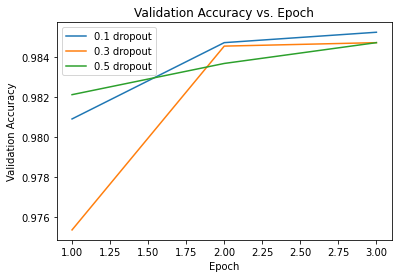

In [ ]:
# Plot validation Loss vs. Epoch
for val_accuracy,dropout in zip(val_accuracies,dropouts):    
    plt.plot(range(1,4),val_accuracy,label=f'{dropout} dropout')
plt.title('Validation Accuracy vs. Epoch')
plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')
x1,x2,y1,y2 = plt.axis()
plt.legend()
plt.show() 

### Initial Learning Rate Fine-tuning

In [ ]:
# Lets try choose the right dropout amount
#https://www.tensorflow.org/tutorials/text/classify_text_with_bert#choose_a_bert_model_to_fine-tune
learningRates = [5e-5,3e-5,2e-5]
val_accuracies=[]
for learningRate in learningRates:
  # Train w/ best dropout
  bert_model = BERT_champion_nn(0.1)
  # Create optimizer w/ learning rate
  optimizer = optimization.create_optimizer(init_lr=learningRate,
                                            num_train_steps=num_train_steps,
                                            num_warmup_steps=num_warmup_steps,
                                            optimizer_type='adamw')
  # Compile
  bert_model.compile(optimizer=optimizer,
                          loss=loss,
                          metrics=metrics)
  # train
  history = bert_model.fit(
      raw_train_ds,
      validation_data=raw_val_ds,
      epochs=epochs)
  print(f'Learning Rate {learningRate}: done.')
  val_accuracies.append(history.history['val_binary_accuracy'])

Epoch 1/3
360/360 [==============================] - 147s 391ms/step - loss: 0.2693 - binary_accuracy: 0.9336 - val_loss: 0.0608 - val_binary_accuracy: 0.9802
Epoch 2/3
360/360 [==============================] - 141s 393ms/step - loss: 0.0393 - binary_accuracy: 0.9871 - val_loss: 0.0545 - val_binary_accuracy: 0.9856
Epoch 3/3
360/360 [==============================] - 142s 393ms/step - loss: 0.0171 - binary_accuracy: 0.9949 - val_loss: 0.0590 - val_binary_accuracy: 0.9852
Learning Rate 5e-05: done.


Epoch 1/3
360/360 [==============================] - 148s 396ms/step - loss: 0.2907 - binary_accuracy: 0.9292 - val_loss: 0.0540 - val_binary_accuracy: 0.9833
Epoch 2/3
360/360 [==============================] - 142s 395ms/step - loss: 0.0477 - binary_accuracy: 0.9838 - val_loss: 0.0528 - val_binary_accuracy: 0.9852
Epoch 3/3
360/360 [==============================] - 143s 398ms/step - loss: 0.0234 - binary_accuracy: 0.9919 - val_loss: 0.0558 - val_binary_accuracy: 0.9859
Learning Rate 3e-05: done.


Epoch 1/3
360/360 [==============================] - 150s 393ms/step - loss: 0.3212 - binary_accuracy: 0.9188 - val_loss: 0.0669 - val_binary_accuracy: 0.9771
Epoch 2/3
360/360 [==============================] - 141s 391ms/step - loss: 0.0494 - binary_accuracy: 0.9817 - val_loss: 0.0542 - val_binary_accuracy: 0.9837
Epoch 3/3
360/360 [==============================] - 140s 390ms/step - loss: 0.0348 - binary_accuracy: 0.9880 - val_loss: 0.0521 - val_binary_accuracy: 0.9842
Learning Rate 2e-05: done.


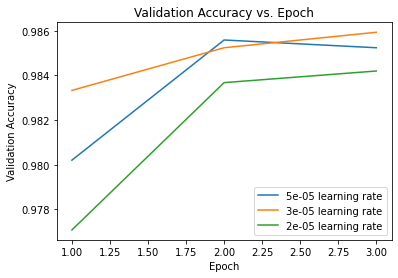

In [ ]:
# Plot validation Loss vs. Epoch
for val_accuracy,learningRate in zip(val_accuracies,learningRates):    
    plt.plot(range(1,4),val_accuracy,label=f'{learningRate} learning rate')
plt.title('Validation Accuracy vs. Epoch')
plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')
x1,x2,y1,y2 = plt.axis()
plt.legend()
plt.show() 

### Label Smoothing Fine Tuning

In [ ]:
# Lets try choose the right dropout amount
#https://www.tensorflow.org/tutorials/text/classify_text_with_bert#choose_a_bert_model_to_fine-tune
labelSmoothings = [.1,.3,.5]
val_accuracies=[]
for labelSmoothing in labelSmoothings:
  # create base model
  bert_model = BERT_champion_nn(0.1)
  # create loss w label smoothing
  loss=losses.BinaryCrossentropy(from_logits=True,label_smoothing=labelSmoothing)
  # Create optimizer
  optimizer = optimization.create_optimizer(init_lr=3e-5,
                                            num_train_steps=num_train_steps,
                                            num_warmup_steps=num_warmup_steps,
                                            optimizer_type='adamw')
  # Compile
  bert_model.compile(optimizer=optimizer,
                          loss=loss,
                          metrics=metrics)
  # Train
  history = bert_model.fit(
      raw_train_ds,
      validation_data=raw_val_ds,
      epochs=epochs)
  print(f'Label Smoothing {labelSmoothing}: done.')
  val_accuracies.append(history.history['val_binary_accuracy'])

Epoch 1/3
360/360 [==============================] - 146s 390ms/step - loss: 0.4096 - binary_accuracy: 0.9316 - val_loss: 0.2354 - val_binary_accuracy: 0.9825
Epoch 2/3
360/360 [==============================] - 141s 391ms/step - loss: 0.2402 - binary_accuracy: 0.9826 - val_loss: 0.2422 - val_binary_accuracy: 0.9783
Epoch 3/3
360/360 [==============================] - 140s 389ms/step - loss: 0.2240 - binary_accuracy: 0.9914 - val_loss: 0.2295 - val_binary_accuracy: 0.9847
Label Smoothing 0.1: done.


Epoch 1/3
360/360 [==============================] - 145s 389ms/step - loss: 0.5754 - binary_accuracy: 0.9283 - val_loss: 0.4483 - val_binary_accuracy: 0.9788
Epoch 2/3
360/360 [==============================] - 140s 388ms/step - loss: 0.4604 - binary_accuracy: 0.9783 - val_loss: 0.4430 - val_binary_accuracy: 0.9795
Epoch 3/3
360/360 [==============================] - 140s 389ms/step - loss: 0.4514 - binary_accuracy: 0.9872 - val_loss: 0.4406 - val_binary_accuracy: 0.9816
Label Smoothing 0.3: done.


Epoch 1/3
360/360 [==============================] - 148s 390ms/step - loss: 0.7005 - binary_accuracy: 0.8870 - val_loss: 0.5837 - val_binary_accuracy: 0.9701
Epoch 2/3
360/360 [==============================] - 141s 392ms/step - loss: 0.5964 - binary_accuracy: 0.9586 - val_loss: 0.5726 - val_binary_accuracy: 0.9802
Epoch 3/3
360/360 [==============================] - 142s 394ms/step - loss: 0.5908 - binary_accuracy: 0.9711 - val_loss: 0.5710 - val_binary_accuracy: 0.9819
Label Smoothing 0.5: done.


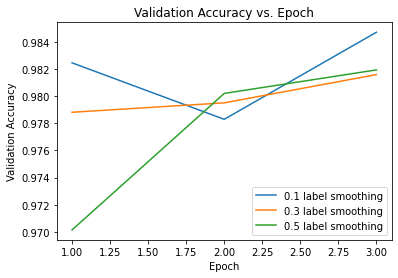

In [ ]:
# Plot validation Loss vs. Epoch
for val_accuracy,labelSmoothing in zip(val_accuracies,labelSmoothings):    
    plt.plot(range(1,4),val_accuracy,label=f'{labelSmoothing} label smoothing')
plt.title('Validation Accuracy vs. Epoch')
plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')
x1,x2,y1,y2 = plt.axis()
plt.legend()
plt.show() 

## Final Model

In [ ]:
from official import nlp

In [ ]:
# Create champion model with best params
best_bert_model,base_bert = BERT_champion_nn(0.1)
loss=losses.BinaryCrossentropy(from_logits=True,label_smoothing=0.1)
epochs=3
metrics = tf.metrics.BinaryAccuracy()
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)
# Create optimizer
optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=num_warmup_steps)
# Compile
best_bert_model.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=metrics)
# Fit
history = best_bert_model.fit(
    raw_train_ds,
    validation_data=raw_val_ds,
    epochs=epochs)

Exception ignored in: <function CapturableResourceDeleter.__del__ at 0x7efe737eb950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/training/tracking/tracking.py", line 208, in __del__
    self._destroy_resource()
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/def_function.py", line 871, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/def_function.py", line 726, in _initialize
    *args, **kwds))
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/function.py", line 2969, in _get_concrete_function_internal_garbage_collected
    graph_function, _ = self._maybe_define_function(args, kwargs)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/p

Epoch 1/3
360/360 [==============================] - 138s 361ms/step - loss: 0.4789 - binary_accuracy: 0.8152 - val_loss: 0.2494 - val_binary_accuracy: 0.9809
Epoch 2/3
360/360 [==============================] - 130s 360ms/step - loss: 0.2481 - binary_accuracy: 0.9796 - val_loss: 0.2371 - val_binary_accuracy: 0.9832
Epoch 3/3
360/360 [==============================] - 130s 360ms/step - loss: 0.2346 - binary_accuracy: 0.9871 - val_loss: 0.2324 - val_binary_accuracy: 0.9842


In [ ]:
# Get test set accuracy
bert_accuracy,bert_tweet_accuracy = runEvaluation(best_bert_model)
print('same dataset evaluation accuracy:')
print(bert_accuracy)
print('twitter dataset evaluation accuracy:')
print(bert_tweet_accuracy)

same dataset evaluation accuracy:
0.9875
twitter dataset evaluation accuracy:
0.5882


### Save Model

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive

'Colab Notebooks'
 deepfake_database.zip
 deeplearning-311117-9649231a1c22.json
'Homework 3 Summary.gdoc'
 IMG_0577.mov
 IMG_0587.mov
'ML Project Report.gdoc'
 Mobile
 Project_Pitch.gslides
'Project Proposal - Data Engineering.gdoc'
 q19.pdf
 Source
 taylorrohrich.jpeg
'University of Virginia - Postgrad'
'University of Virginia - Undergrad'
'Untitled document.gdoc'
 weights


In [ ]:
# Save model locally
export_dir='new_saved_model/bert'
tf.saved_model.save(best_bert_model, export_dir=export_dir)

INFO:tensorflow:Assets written to: new_saved_model/bert/assets


INFO:tensorflow:Assets written to: new_saved_model/bert/assets


In [ ]:
# Reload model to ensure it works
reloaded = tf.saved_model.load(export_dir)

In [ ]:
# Make sample prediction
reloaded(['Microsoft Flight Simulator series grounded after layoffs'],training=False)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.0379065]], dtype=float32)>

In [ ]:
!zip -r new_saved_model/bert.zip new_saved_model/bert


  adding: new_saved_model/bert/ (stored 0%)
  adding: new_saved_model/bert/assets/ (stored 0%)
  adding: new_saved_model/bert/assets/vocab.txt (deflated 53%)
  adding: new_saved_model/bert/variables/ (stored 0%)
  adding: new_saved_model/bert/variables/variables.data-00000-of-00001 (deflated 24%)
  adding: new_saved_model/bert/variables/variables.index (deflated 79%)
  adding: new_saved_model/bert/saved_model.pb (deflated 92%)


In [ ]:
import tensorflow as tf
tf.version.VERSION

'2.4.1'

In [ ]:
# Download zipped model
from google.colab import files
files.download("new_saved_model/bert.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Hitting Endpoint

In [ ]:
import os
# Grab credentials from google drive
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/content/drive/MyDrive/deeplearning-311117-00aef06ca193.json"

In [ ]:
import googleapiclient.discovery
from google.api_core.client_options import ClientOptions
# Helper function from Google to predict
def predict_json(project, region, model, instances, version=None):
    """Send json data to a deployed model for prediction.

    Args:
        project (str): project where the Cloud ML Engine Model is deployed.
        region (str): regional endpoint to use; set to None for ml.googleapis.com
        model (str): model name.
        instances ([Mapping[str: Any]]): Keys should be the names of Tensors
            your deployed model expects as inputs. Values should be datatypes
            convertible to Tensors, or (potentially nested) lists of datatypes
            convertible to tensors.
        version: str, version of the model to target.
    Returns:
        Mapping[str: any]: dictionary of prediction results defined by the
            model.
    """
    # Create the ML Engine service object.
    # To authenticate set the environment variable
    #GOOGLE_APPLICATION_CREDENTIALS='/content/drive/MyDrive/deeplearning-311117-9649231a1c22.json'
    prefix = "{}-ml".format(region) if region else "ml"
    api_endpoint = "https://{}.googleapis.com".format(prefix)
    client_options = ClientOptions(api_endpoint=api_endpoint)
    service = googleapiclient.discovery.build(
        'ml', 'v1', client_options=client_options)
    name = 'projects/{}/models/{}'.format(project, model)

    if version is not None:
        name += '/versions/{}'.format(version)

    response = service.projects().predict(
        name=name,
        body={'instances': instances}
    ).execute()

    if 'error' in response:
        raise RuntimeError(response['error'])

    return response['predictions']

In [ ]:
# Sample predictions
predict_json('deeplearning-311117','us-central1','dlmodel',['The New "Star Wars: The Force Awakens" Trailer Is Here To Give You Chills']
,'dlmodel1')

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/__init__.py", line 44, in autodetect
    from . import file_cache
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 41, in <module>
    "file_cach

[[0.967878282]]

## Model Interpretability

In [ ]:
# Examples of clickbait, normal
clickbaitExamples = ['The New "Star Wars: The Force Awakens" Trailer Is Here To Give You Chills','21 Times I Died During The "Captain America: Civil War" Teaser']
normalExamples = ['Microsoft Flight Simulator series grounded after layoffs','Former Texas nurse charged with murder for allegedly injecting bleach into patients']

In [ ]:
# Helper function to generate latent features
def getLatentFeatures(textArray):
  latentArray = []
  for text in textArray:
    text_preprocessed = bert_preprocess_model([text])
    result = base_bert(text_preprocessed)
    latentArray.append(result['sequence_output'][0].numpy().flatten())
  return latentArray
# Helper function to get cosine similarity
def getCosineSimilarity(itemOne,itemTwo):
  return sklearn.metrics.pairwise.cosine_similarity(itemOne.reshape(1, -1),itemTwo.reshape(1, -1))[0][0]
# Helper function to generate cosine similarity matrix
def getCosineSimilarityMatrix(items):
  cosineArray = [[0 for y in items] for x in items]
  for i,itemsI in enumerate(items):
    for j,itemsJ in enumerate(items):
      cosineArray[i][j] = getCosineSimilarity(itemsI,itemsJ)
  return pd.DataFrame(cosineArray,columns=['clickbait1','clickbait2','normal1','normal2'],index=['clickbait1','clickbait2','normal1','normal2'])



In [ ]:
# Create cosine similarity matrix
clickbaitLatentFeatures = getLatentFeatures(clickbaitExamples)
normalLatentFeatures = getLatentFeatures(normalExamples)
getCosineSimilarityMatrix(clickbaitLatentFeatures+normalLatentFeatures)

,clickbait1,clickbait2,normal1,normal2
clickbait1,1.000000,0.622230,0.183701,0.287847
clickbait2,0.622230,1.000000,0.267531,0.349949
normal1,0.183701,0.267531,1.000000,0.606339
normal2,0.287847,0.349949,0.606339,1.000000


In [ ]:
# example from base bert
result = base_bert(text_preprocessed)

In [ ]:
# Show latent features
result['sequence_output']

<tf.Tensor: shape=(1, 128, 512), dtype=float32, numpy=
array([[[-0.6079963 ,  0.39447516,  0.09507024, ...,  0.40678787,
          0.703994  , -0.85021687],
        [-0.03237642,  0.03271692, -0.16828474, ...,  0.58286166,
          0.25717533,  0.18844631],
        [-1.3570883 ,  0.356217  ,  0.35640708, ...,  0.35901335,
         -0.36589634, -0.1805216 ],
        ...,
        [-0.21005103, -0.325299  , -1.1188972 , ...,  0.06799783,
          0.99034095,  0.5500885 ],
        [-0.67435676, -0.73463523, -0.88314736, ...,  0.3144946 ,
          0.61783266,  0.32381946],
        [-0.7836961 ,  0.03416079, -0.5595659 , ...,  0.6800343 ,
          0.7856271 , -0.3649732 ]]], dtype=float32)>

## Feature Importance

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import nltk
# Read train data
df = pd.read_csv('clickbait_train.csv')
documents= df['headline'].values
labels = df['clickbait'].values

In [ ]:
!pip install TextFeatureSelection
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from TextFeatureSelection import TextFeatureSelection
from nltk.corpus import stopwords
#https://pypi.org/project/TextFeatureSelection/
#Multiclass classification problem
# Generate feature importance
fsOBJ=TextFeatureSelection(target=list(labels),input_doc_list=list(documents),stop_words=stopwords.words('english'))
result_df=fsOBJ.getScore()
print(result_df)


      word list  word occurence count  ...  Chi Square  Information Gain
0            00                     3  ...    0.337550          0.000003
1           000                   116  ...   72.876533          0.000511
2         000th                     1  ...    0.995877          0.000007
3           00s                    50  ...   50.296088          0.000000
4            01                     1  ...    0.995877          0.000007
...         ...                   ...  ...         ...               ...
21654   íslands                     1  ...    0.995877          0.000007
21655       île                     1  ...    0.995877          0.000007
21656    ürümqi                     1  ...    0.995877          0.000007
21657       śrī                     1  ...    0.995877          0.000007
21658   šibenik                     1  ...    0.995877          0.000007

[21659 rows x 6 columns]


In [ ]:
# Get top features by information gain
result_df.sort_values(by='Information Gain',ascending=False)[0:15]

,word list,word occurence count,Proportional Difference,Mutual Information,Chi Square,Information Gain
19453,things,890,0.993258,-5.001543,909.848313,0.015099
10808,know,718,0.986072,-4.275966,719.021029,0.011729
616,actually,542,0.992620,-4.911053,546.561857,0.009107
1942,based,561,0.964349,-3.336070,534.381188,0.008344
11740,make,725,0.881379,-2.133906,580.482318,0.008060
14228,people,904,0.811947,-1.673112,618.446223,0.008004
184,21,605,0.910744,-2.418326,514.937751,0.007414
84,17,641,0.890796,-2.216615,522.661316,0.007343
98,19,539,0.922078,-2.554127,469.127754,0.006861
11315,like,471,0.910828,-2.419270,399.062811,0.005757
